In [2]:
# We knew most of the solutions in the portfolio where its application of robust risk optimization.
#Hence, we dont need to use solver or corresponding functions in Scipy/ Numpy Library

In [1]:
import numpy as np
from numpy.linalg import det, inv, eigvals

import scipy
from scipy.optimize import minimize, LinearConstraint, Bounds

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
mu_i = 0.1
sig_ii = 0.3
rho_ij = 0.25
n = 10

gamma = 1

In [3]:
mu = np.full(n, mu_i)
Sigma = np.full((n, n), rho_ij*sig_ii*sig_ii)

# Set the diagonal elements to the diagonal value
np.fill_diagonal(Sigma, sig_ii*sig_ii)


### Nominal Portfolio

In [8]:
# All weights must be between 0 and 1, so set 0 and 1 as the boundaries.
bounds = Bounds(0, 1)

# Set the constraint that the sum of weights equals 1.
ones_for_sum = np.ones((1, n))
linear_constraint = LinearConstraint(ones_for_sum, [1], [1])

initial_weights = np.ones(n) / n

def variance(a, Sigma):
    return np.dot(a, np.dot(a, Sigma))
    
def objective_nom(a, Sigma): #calculate portfolio risk
    return (gamma/2)*np.dot(a, np.dot(a, Sigma))- np.dot(a, mu)

# Minimize the risk function using the 'trust-constr' method with linear constraint and bounds.
res = minimize(objective_nom, initial_weights, method='trust-constr', constraints=linear_constraint, bounds=bounds, args = (Sigma))
a_hat = res.x
print("Optimal Weights:", a_hat)

# The corresponding relative entropy with this is zero, because we haven't changed the distribution
E_Va = variance(a_hat, Sigma)
print(E_Va)

Optimal Weights: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
0.029249999999999995


### Worst Case Portfolio

In [5]:
# Plan- calculate the entrophy using explicit expression
# Calculate the max mean-variance objective using simulations?

In [5]:
I = np.eye(n)

#speciific case for analysis
theta_ = 0.2

def objective_a_oftheta(a, theta):
    term1 = 1 / np.sqrt(det(I - theta * gamma * np.outer(a,a) @ Sigma))
    return (1/theta)*np.log(term1) - a.T @ mu

def positive_definite_constraint(a, theta):
    eigenvalues = eigvals(inv(Sigma) - theta * gamma * np.outer(a,a) )
    return np.min(eigenvalues) - 1e-10  # Ensure all eigenvalues are slightly greater than zero


In [14]:
# monte-carlo sampling optimization, because the above one does not works
n_points = 100000
points_on_hyperplane = np.zeros((n_points, 10))

for j in range(n_points):
    random_numbers = np.random.rand(10)
    # Normalize the numbers so their sum is 10
    normalized_numbers = random_numbers / random_numbers.sum() 

    points_on_hyperplane[j] = normalized_numbers

In [7]:
min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta_)
first_positive = np.argmax(min_eig_vals > 0)
a0 = points_on_hyperplane[first_positive]

C:\Users\prith\anaconda3\Lib\site-packages\numpy\lib\shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


In [8]:
print(first_positive, a0)

0 [0.11241958 0.16247161 0.03760114 0.15458621 0.08508036 0.12645335
 0.15357309 0.00244369 0.12925596 0.03611503]


In [9]:
# Initial guess for 'a'
#a0 = points_on_hyperplane[1]

# Define constraints in the format required by 'minimize'
constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta_,)},
    linear_constraint
] 

# Perform the optimization
result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=None, args = (theta_))

# Check if the optimization was successful
if result.success:
    a_star = result.x
    print("Optimized a:", a_star)
    print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
else:
    print("Optimization failed:", result.message)

Optimized a: [0.10000401 0.10002226 0.09997795 0.10001973 0.09999353 0.10001002
 0.10001881 0.0999657  0.10001082 0.09997716]
 Minimum adjective reached at -0.08533205417934149 Not portfolio objective!


C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


In [10]:
# Using the Monte Carlo based approximate optimization, if the above method does not work
# Segregating out the invalid portfolio vectors
indices = np.where(min_eig_vals < 0)[0]
# Observation. All the segregated out indices produce nan value in the objective evaluation !

objective_val = np.apply_along_axis(objective_a_oftheta, axis=1, arr=points_on_hyperplane, theta = theta_)
min_arg = np.nanargmin(objective_val)
a_star2 = points_on_hyperplane[min_arg]

In [11]:
print("Optimized a:", a_star2)
print(" Minimum adjective reached at", objective_val[min_arg])

Optimized a: [0.09745786 0.12508631 0.0938633  0.08952986 0.10416337 0.09932707
 0.10039697 0.09290838 0.08874888 0.10851801]
 Minimum adjective reached at -0.08529639281346607


In [12]:
#computaion of entropy, risk_measuremennt
#mvo = mean variance objective
Sigma_tilda = inv(inv(Sigma) - theta_ * gamma * np.outer(a_star, a_star))

entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2

RPs_nominal = objective_nom(a_star, Sigma)
NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)

risk_meas2 = -np.dot(a_star, mu) + (gamma/2)*np.dot(a_star, np.dot(a_star, Sigma_tilda))
# Both of them are the same

Scipy optimize based optimization

In [15]:
# monte-carlo sampling optimization, because the above one does not works
n_points = 1000
points_on_hyperplane = np.zeros((n_points, 10))

for j in range(n_points):
    random_numbers = np.random.rand(10)
    # Normalize the numbers so their sum is 10
    normalized_numbers = random_numbers / random_numbers.sum() 

    points_on_hyperplane[j] = normalized_numbers

In [58]:
results_ = {}
thetas = (np.exp(np.linspace(0, 3)) - 1)[1:]
for theta in thetas:
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint, axis=1, arr=points_on_hyperplane, theta = theta)
    first_positive = np.argmax(min_eig_vals > 0)
    a0 = points_on_hyperplane[first_positive]

    constraints = [
    {'type': 'ineq', 'fun': positive_definite_constraint, 'args': (theta,)},
    linear_constraint
    ] 
    
    # Perform the optimization
    result = minimize(objective_a_oftheta, a0, method='SLSQP', constraints=constraints, bounds=bounds, args = (theta))
    
    # Check if the optimization was successful
    if result.success:
        a_star = result.x
        print("Optimized a:", a_star)
        print(" Minimum adjective reached at", np.real(result.fun), "Not portfolio objective!")
    else:
        print("Optimization failed:", result.message)
    
    #computaion of entropy, risk-measurement
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = objective_nom(a_star, Sigma)
                    
    NP_worstcase = objective_nom(a_hat, Sigma_tilda)
    RPs_worstcase = objective_nom(a_star, Sigma_tilda)
    
    results_[theta] = (entropy, RPs_nominal, NP_worstcase, RPs_worstcase)

C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:598: ComplexWarning: Casting complex values to real discards the imaginary part
  J_transposed[i] = df / dx


Optimized a: [0.10001234 0.09999798 0.09999842 0.09999321 0.09999449 0.10001146
 0.09999958 0.10000608 0.09999842 0.09998802]
 Minimum adjective reached at -0.08536147880158705 Not portfolio objective!
Optimized a: [0.10002121 0.0999982  0.09999685 0.099987   0.09999105 0.10002124
 0.09999775 0.10000865 0.09999931 0.09997873]
 Minimum adjective reached at -0.085347067264782 Not portfolio objective!
Optimized a: [0.10003004 0.09999743 0.09999553 0.09998311 0.09998817 0.10002918
 0.0999951  0.10001368 0.09999904 0.09996873]
 Minimum adjective reached at -0.08533170422376653 Not portfolio objective!
Optimized a: [0.10004344 0.09999606 0.09999349 0.09997388 0.09998097 0.1000434
 0.09999402 0.10002063 0.09999925 0.09995486]
 Minimum adjective reached at -0.08531532390661417 Not portfolio objective!
Optimized a: [0.10005471 0.09999564 0.09999184 0.09996681 0.099976   0.10005479
 0.09999289 0.10002649 0.09999898 0.09994184]
 Minimum adjective reached at -0.08529785572852303 Not portfolio obje

C:\Users\prith\anaconda3\Lib\site-packages\scipy\optimize\_slsqp_py.py:422: ComplexWarning: Casting complex values to real discards the imaginary part
  slsqp(m, meq, x, xl, xu, fx, c, g, a, acc, majiter, mode, w, jw,


Optimized a: [0.10028087 0.09997642 0.09995915 0.09983017 0.09987693 0.10028128
 0.09996088 0.10013477 0.0999946  0.09970494]
 Minimum adjective reached at -0.08496866382590153 Not portfolio objective!
Optimized a: [0.10030802 0.09997432 0.09995519 0.09981371 0.09986496 0.10030847
 0.09995706 0.1001478  0.09999403 0.09967644]
 Minimum adjective reached at -0.08492736563532316 Not portfolio objective!
Optimized a: [0.10033719 0.09997177 0.09995099 0.09979622 0.09985223 0.10033762
 0.09995299 0.10016171 0.09999348 0.09964579]
 Minimum adjective reached at -0.08488312456735496 Not portfolio objective!
Optimized a: [0.10036777 0.09996919 0.09994654 0.09977763 0.09983883 0.10036827
 0.0999488  0.10017647 0.09999287 0.09961363]
 Minimum adjective reached at -0.08483570610220906 Not portfolio objective!
Optimized a: [0.10040027 0.09996646 0.09994177 0.09975798 0.09982449 0.10040093
 0.0999443  0.1001921  0.09999225 0.09957944]
 Minimum adjective reached at -0.08478485333266629 Not portfolio o

In [59]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results_.items()]

# Create a DataFrame
df_wc = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'RPs_nominal', 'NPs_worstcase', 'RPs_worstcase'])

Using Monte carlo sample based approximate optimization

In [57]:
results2_ = {}
thetas = (np.exp(np.linspace(0, 3)) - 1)[1:]
for theta in thetas:

    def objective_t(a):
        return objective(theta, a)
        
    def positive_definite_constraint_t(a):
        return positive_definite_constraint(theta, a)
    
    min_eig_vals = np.apply_along_axis(positive_definite_constraint_t, axis=1, arr=points_on_hyperplane)
    
    no_invalid = np.sum(np.real(min_eig_vals) < 0)
    if (no_invalid):
        print("No of invalid points for theta=", theta, "hyperplane:", no_invalid)
    
    objective_val = np.apply_along_axis(objective_t, axis=1, arr=points_on_hyperplane)
    min_arg = np.nanargmin(objective_val)
    a_star = points_on_hyperplane[min_arg]
    
    #computaion of entropy, 
    Sigma_tilda = inv(inv(Sigma) - theta * gamma * np.outer(a_star, a_star))
    
    entropy = (np.log(det(np.matmul(Sigma, inv(Sigma_tilda)) )) + np.trace(np.matmul(inv(Sigma), Sigma_tilda) - I))/2
    
    RPs_nominal = objective_nom(a_star)
    NPs_worstcase = -np.dot(a_hat, mu) + (gamma/2)* np.dot(np.matmul(a_hat, Sigma_tilda), a_hat)
    RPs_worstcase = -np.dot(a_star, mu) + (gamma/2)* np.dot(np.matmul(a_star, Sigma_tilda), a_star)
    
    results2_[theta] = (entropy, RPs_nominal, NPs_worstcase, RPs_worstcase)

C:\Users\prith\anaconda3\Lib\site-packages\numpy\lib\shape_base.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  buff[ind] = asanyarray(func1d(inarr_view[ind], *args, **kwargs))


NameError: name 'objective' is not defined

In [139]:
# Convert the dictionary to a list of tuples
data_list = [(key, *value) for key, value in results2_.items()]

# Create a DataFrame
df_wc1 = pd.DataFrame(data_list, columns=['Theta', 'Entropy', 'Risk'])

In [145]:
df_wc1

,Theta,Entropy,Risk
0,0.000000,2.664535e-15,-0.072834
1,0.041661,4.001459e-07,-0.084810
2,0.085057,1.670896e-06,-0.084790
3,0.130261,3.926053e-06,-0.084769
4,0.177349,7.291430e-06,-0.084747
5,0.226398,1.190606e-05,-0.084724
6,0.277491,1.792353e-05,-0.084700
7,0.330712,2.551346e-05,-0.084675
8,0.386151,3.486314e-05,-0.084649
9,0.443899,4.617929e-05,-0.084622


In [46]:
#df_wc = pd.DataFrame(np.real(df_wc))
#df_wc.columns = ['Theta', 'Entropy', 'RPs_nominal', 'NPs_worstcase', 'RPs_worstcase']

In [60]:
df_wc

,Theta,Entropy,RPs_nominal,NPs_worstcase,RPs_worstcase
0,0.063138,8.547469e-07,-0.085375,-0.085348,-0.085348
1,0.130261,3.647823e-06,-0.085375,-0.085319,-0.085319
2,0.201623,8.763909e-06,-0.085375,-0.085288,-0.085288
3,0.277491,1.664972e-05,-0.085375,-0.085255,-0.085255
4,0.358149,2.782363e-05,-0.085375,-0.085220,-0.085220
5,0.443899,4.288677e-05,-0.085375,-0.085183,-0.085183
6,0.535063,6.253598e-05,-0.085375,-0.085142,-0.085142
7,0.631983,8.757876e-05,-0.085375,-0.085100,-0.085100
8,0.735023,1.189507e-04,-0.085375,-0.085054,-0.085054
9,0.844568,1.577358e-04,-0.085375,-0.085005,-0.085005


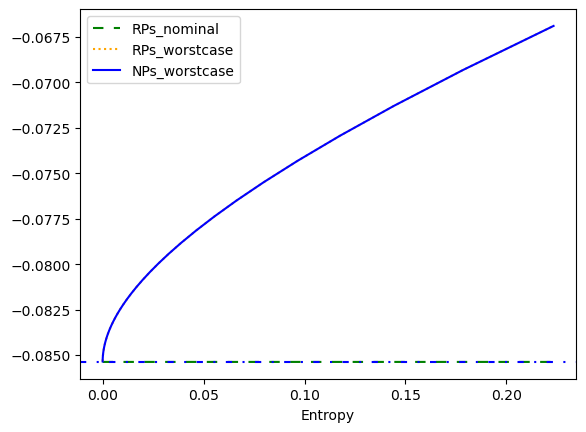

In [61]:
ax = plt.gca()
df_wc.plot(ax = ax, x='Entropy',y='RPs_nominal', linestyle=(0, (5, 5)), linewidth=1.5, color='green')
ax.axhline(y = E_Va, color = 'b', linestyle = (0, (3, 5, 1, 5)))
df_wc.plot(ax = ax, x='Entropy',y='RPs_worstcase', linestyle='dotted', linewidth=1.5, color='orange')
df_wc.plot(ax = ax, x='Entropy',y='NPs_worstcase', linestyle='solid', linewidth=1.5, color='blue')
plt.show()